1. > # In-Depth: Breast Cancer Prediction step by step: 97% accuracy

Cancer occurs when mutation or abnormal changes happen in genes that regulate cell growth i.e. multiplication of cells in an uncontrolled way. If breast cell is mutated and grown in an uncontrolled way then we call it Breast Cancer. Cancer forms in either lobules or ducts of the breast. Among the most common cancer seen in women in the United States, Breast cancer holds the second position. It does not mean it won't happen in men, it is just not common in men. Breast cancer survival rates have increased and the number of death associated with it is steadily declining due to earlier detection. Earlier we detect the cancer cell, better the chance of survival.

Here we will be preparing a model to predict whether the tumor is Benign or Malignant so that appropriate action could be taken on time to save a life. Benign tumors are not considered cancerous; their cell is close to normal in appearance and they grow slowly without invading nearby tissues and spread other parts of the body whereas Malignant are aggressive. Malignant tumors are cancerous, if not checked then it will eventually spread beyond the original tumor part.

#### Data Source:
The data source we will be using here is from Kaggle which can also be found in UCI Machine Learning Repository.

- Kaggle: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

- UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

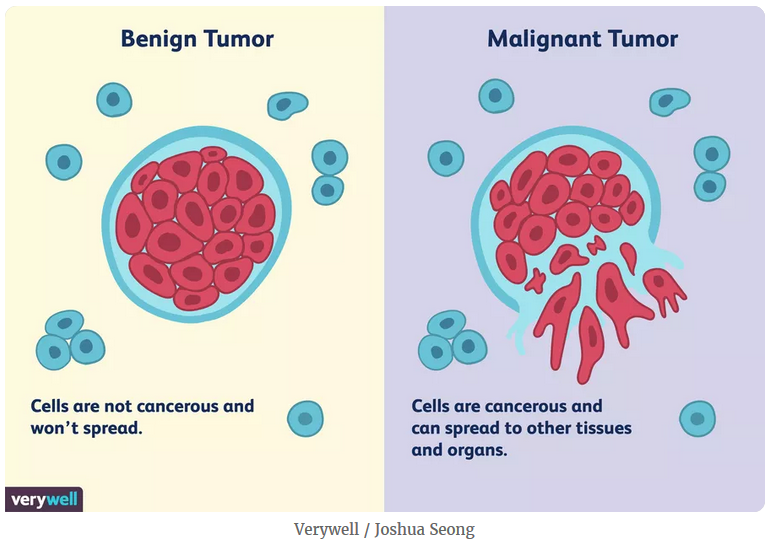



In this dataset, we have 10 features of the cell along with the diagnosis info.

#### Attribute Information:
* ID number
* Diagnosis **(M = malignant, B = benign)**z

Ten real-valued features are computed for each cell nucleus:
* **radius** (mean of distances from center to points on the perimeter)
* **texture** (standard deviation of gray-scale values)
* **perimeter**
* **area**
* **smoothness** (local variation in radius lengths)
* **compactness** (perimeter^2 / area - 1.0)
* **concavity** (severity of concave portions of the contour)
* **concave points** (number of concave portions of the contour)
* **symmetry**


The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. 

*z fractal dimension ("coastline approximation" - 1)

#### Lets import the library that we will be using


In [ ]:
# import the library

# for data load and data manupulation, data analysis
import pandas as pd

# for data computation in matrix form or mullti-dimensional arrays
import numpy as np

#for figure
from sklearn import model_selection

#sklearn data preparing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#sklearn scaling and labelencoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#sklearn model optimization
from sklearn.model_selection import GridSearchCV

# sklearn metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

#plot
import matplotlib.pyplot as plt
import seaborn as sns

#save model
import pickle

# display image
from IPython.display import Image

### Load the data from csv file.

In [ ]:
df_raw = pd.read_csv("../input/breast-cancer-wisconsin-data/data.csv")
df_raw.head()

In [ ]:
print('Dataset contains')
print("Number of rows:",df_raw.shape[0])
print("Number of columns:",df_raw.shape[1])

In [ ]:
df_raw.columns

Here, we don't need column [id] since it does not provide any value here. And if you see the column [Unnamed: 32], there are NaN values. So, let's remove those two columns. 

In [ ]:
df = df_raw.drop('id',axis=1).drop('Unnamed: 32',axis=1)
df.head(2)

#### Let's find out if there is null value present in data or not

In [ ]:
df.isnull().sum()

There is no null or empty field so we are good to proceed.

#### Let's check if columns data type and see if all the column data type is assigned correctly or not

In [ ]:
df.dtypes

#### Here, the datatype of diagnosis is object so let's make more specific to categorical type

In [ ]:
df['diagnosis'] = df['diagnosis'].astype('category')

In [ ]:
df.dtypes

### Let's separate the target data and feature data

In [ ]:
print("X is the features and Y is the target data")
X= df.drop('diagnosis',axis=1)
Y= df['diagnosis']

### Normalization and Feature Scaling

Why do we need normalization?

Normalization involves rescaling the features in such a way that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. Are all the features equally important? No, it depends on which model you are using for prediction but it is recommended to use normalization before running model. 

- ***Clustering: Required Normalization***
- ***PCA: Required Normalization***
- ***SVM: Required Normalization***
- ***LASSO AND RIDGE REGRESSION: Required Normalization***

In [ ]:
# let do standardscaling then
model_scaler = StandardScaler()
X_norm =model_scaler.fit_transform(X)
X_norm = pd.DataFrame(X_norm,columns=X.columns)
X_norm.head(3)

# Data Visualization

### What is Correlation and why is it important?

Correlation is defined as how close two variables are to have a linear relationship with each other. 
- Positive Correlation(+1): variable increase together
- Negative Correlation(-1):  when one variable increases as the other decrease
- No correlation(0): variable does not have any linear relation

## Why is Correlation useful?

- the correlated variable can be used in prediction for each other which can be used in impute missing values
- correlated variables indicate the presence of a causal relationship.
- Correlation is used as a basic quantity for many modeling techniques
- For checking redundancy of variables

<img src="../input/image/cancer.PNG" />




In [ ]:
#explore correlation
plt.rcParams['figure.figsize']=[38,16]
sns.set(font_scale=1.4)
corr = X.corr()
mask_upper_traingle = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr,mask=mask_upper_traingle, cmap='coolwarm', annot=True, fmt='.1')

From the correlation matrix, we can see some of the features are highly correlated: 
- perimeter_worst - radius_mean
- perimeter_worst - perimeter_mean
- area_worst - perimeter_worst, etc

Since these features are correlated, it could be used to predict another variable if there are missing variable but luckily we don't have a missing data point.

In [ ]:
# sorted correlationmatrix
def sort_and_createCorrelationMatrix(dt):
    corr_matrix = dt.corr().abs()
    corr_sorted = corr_matrix.stack().sort_values(ascending=False)
    corr_sorted = pd.DataFrame(corr_sorted)
    corr_sorted.reset_index(inplace=True)

    corr_sorted.columns=['level_0', 'level_1', 'value']
    corr_sorted =corr_sorted.pivot(index ='level_0', columns ='level_1', values='value') 
    mask_upper_traingle = np.triu(np.ones_like(corr_sorted, dtype=np.bool))
    sns.heatmap(corr_sorted,mask=mask_upper_traingle, cmap='coolwarm', annot=True, fmt='.1')


### Box Plot Visualizaiton

Box plot gives the idea of data distribution based on:
- First quartile (Q1)
- Median
- Third quartile (Q3)
- Minimum
- Maximum

<img src="../input/image/boxplot.PNG" />


Through this box plot, we can see if there are outliers or not in the data. If there are outliers then we need a plan to handle it. Sometime outlier plays a vital role so it is not always ideal to remove outlier straight forward.

In [ ]:
plt.rcParams['figure.figsize']=(18,5)
fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)=plt.subplots(1,10)
sns.boxplot(x='diagnosis',y='radius_mean',data=df,ax=ax1)
sns.boxplot(x='diagnosis',y='texture_mean',data=df,ax=ax2)
sns.boxplot(x='diagnosis',y='perimeter_mean',data=df,ax=ax3)
sns.boxplot(x='diagnosis',y='area_mean',data=df,ax=ax4)
sns.boxplot(x='diagnosis',y='smoothness_mean',data=df,ax=ax5)
sns.boxplot(x='diagnosis',y='compactness_mean',data=df,ax=ax6)
sns.boxplot(x='diagnosis',y='concavity_mean',data=df,ax=ax7)
sns.boxplot(x='diagnosis',y='concave points_mean',data=df,ax=ax8)
sns.boxplot(x='diagnosis',y='symmetry_mean',data=df,ax=ax9)
sns.boxplot(x='diagnosis',y='fractal_dimension_mean',data=df,ax=ax10)
fig.tight_layout()

fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)=plt.subplots(1,10)
sns.boxplot(x='diagnosis',y='radius_se',data=df,ax=ax1)
sns.boxplot(x='diagnosis',y='texture_se',data=df,ax=ax2)
sns.boxplot(x='diagnosis',y='perimeter_se',data=df,ax=ax3)
sns.boxplot(x='diagnosis',y='area_se',data=df,ax=ax4)
sns.boxplot(x='diagnosis',y='smoothness_se',data=df,ax=ax5)
sns.boxplot(x='diagnosis',y='compactness_se',data=df,ax=ax6)
sns.boxplot(x='diagnosis',y='concavity_se',data=df,ax=ax7)
sns.boxplot(x='diagnosis',y='concave points_se',data=df,ax=ax8)
sns.boxplot(x='diagnosis',y='symmetry_se',data=df,ax=ax9)
sns.boxplot(x='diagnosis',y='fractal_dimension_se',data=df,ax=ax10)
fig.tight_layout()

plt.rcParams['figure.figsize']=(17,5)
fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)=plt.subplots(1,10)
sns.boxplot(x='diagnosis',y='radius_worst',data=df,ax=ax1)
sns.boxplot(x='diagnosis',y='texture_worst',data=df,ax=ax2)
sns.boxplot(x='diagnosis',y='perimeter_worst',data=df,ax=ax3)
sns.boxplot(x='diagnosis',y='area_worst',data=df,ax=ax4)
sns.boxplot(x='diagnosis',y='smoothness_worst',data=df,ax=ax5)
sns.boxplot(x='diagnosis',y='compactness_worst',data=df,ax=ax6)
sns.boxplot(x='diagnosis',y='concavity_worst',data=df,ax=ax7)
sns.boxplot(x='diagnosis',y='concave points_worst',data=df,ax=ax8)
sns.boxplot(x='diagnosis',y='symmetry_worst',data=df,ax=ax9)
sns.boxplot(x='diagnosis',y='fractal_dimension_worst',data=df,ax=ax10)
fig.tight_layout()


From this box plot, we can see Malignant is bigger in size than Benign for most to the feature mean except fractual_dimesions mean. Similar characteristics appear in feature _worst. But the standard error has quite a different result. Texture_se, Smoothness_se, and symmetry_se are higher for Benign.

We can also see lots of outliers are present in the data. The black dotes in the box plot show outlier in data.

In [ ]:
# check the distribution of data
fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'radius_mean', hist=True, rug=True )

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'perimeter_mean', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'smoothness_mean', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'concavity_mean', hist=True, rug=True)


fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'radius_se', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'perimeter_se', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'smoothness_se', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'concavity_se', hist=True, rug=True)


fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'radius_worst', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'perimeter_worst', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'smoothness_worst', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'concavity_worst', hist=True, rug=True)

fig = sns.FacetGrid(df,col='diagnosis', hue='diagnosis')
fig.map(sns.distplot, 'symmetry_worst', hist=True, rug=True)

From the above data distribution plot, we can see most of them have normal data distribution. Some the feature are right-skewed like radius_se, perimeter_se, smoothness_se, concavity_se, etc. There is a different way of handling the skewed data but for now, we will leave as it is.

# Encode the Categorical variables

If you check the diagnosis, there are two categories and which is in object format so we need to convert into numerical value so that it can be used in the model

In [ ]:
Y.value_counts()

We are using LabelEncoder from sklearn to convert the string categorical to a numerical value.

In [ ]:
model_encoder = LabelEncoder()
Y_norm = model_encoder.fit_transform(Y)
print(model_encoder.classes_)
print(model_encoder.transform(model_encoder.classes_))
Y_norm = pd.DataFrame(Y_norm,columns=['diagnosis'])
Y_norm.head(5) 

We can see there are more Benign than Malignant data i.e. 63% data are Benign and 37% are Malignant. So, the data is not distributed equally. If we build a model out of it, it own perform better since our model will know about Benign more than Malignant. So, we have to be fair while training the model.

Here the data is a really small amount so we cannot undersize the sample to make it equal M and B. Instead let's do over sample by using oversampling technique call **SMOTE (Synthetic Minority Over-sampling Technique )**

In [ ]:
Y.value_counts()/len(Y)

In [ ]:
# SMOTE: Synthetic Minority Over-sampling Technique 
from imblearn.over_sampling import SMOTE

model_smote =SMOTE(random_state=13)
X_norm, Y_norm = model_smote.fit_resample(X_norm,Y_norm)

I made a custom build code that will be used to fit the model by tuning parameter. Essential we are using the GridSearchCV for parameter tuning.

In [ ]:
def FitModelByParameterTuning(X,Y,algo_name, algorithm,gridSearchParams,cv, result=None):
    np.random.seed(13)
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
    
    gridSearch = GridSearchCV(
        estimator=algorithm,
        param_grid=gridSearchParams,
        cv = cv,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1)
    gridSearch_result = gridSearch.fit(x_train,y_train)
    best_params = gridSearch_result.best_params_
    pred = gridSearch_result.predict(x_test)
    cm=confusion_matrix(y_test,pred)
    
    ### print the result
    print('Best Params:', best_params)
    print('Classification Report:\n', classification_report(y_test,pred))
    print('Accuracy Score:', str(accuracy_score(y_test,pred)))
    print('Confusion Matrix:\n',cm)
    if result is not None:
        result_data.append([str(gridSearch_result.estimator).split('(')[0],accuracy_score(y_test,pred)])
    
    return [gridSearch_result,str(accuracy_score(y_test,pred))]

Our Cancer Prediction problem is the classification problem so we will apply various classification algorithm to get the result and see which one will perform better. Here are some of the classification model/algorithm we can apply:

- Linear Classifiers
    - Logistic regression
    - Naive Bayes classifier
    - Fisher’s linear discriminant
- Support vector machines
    - Least squares support vector machines
- Quadratic classifiers
- Kernel estimation
    - k-nearest neighbor 
- Decision trees
    - Random forests
    - XGBoost 
- Neural networks
- Learning vector quantization

Let's begin to test the different algorithm:


###  Model Logistic Regression
### 1. Logistic Regression

In [ ]:
# data frame to for result
result_data =[]
#result_df = pd.DataFrame(result_data,columns=['Model','Accuracy'])

# Logistic Regression
param = {
    'penalty' : ['l1', 'l2','elastic-net']
}
model_Logistic = FitModelByParameterTuning(X_norm, Y_norm, 'LogisticRegression', LogisticRegression(), param, cv=5, result=result_data)

### 2. Support Vector Classification (SVC)

In [ ]:

param = {
    'C':[0.1,1,100,1000],
    'gamma':[0.0001,0.001, 0.005, 0.1, 1, 3, 5]
}
model_SVC = FitModelByParameterTuning(X_norm, Y_norm, 'SVC', SVC(), param, cv=5, result=result_data)

### 3. Random Forest

In [ ]:
param={
    "n_estimators":[100,500,1000,2000]
}

model_RandomForest = FitModelByParameterTuning(X_norm, Y_norm, 'Random Forest', RandomForestClassifier(), param, cv=5, result=result_data)


### 4. XGBClassifier()

In [ ]:
param={
    'n_estimators':[100,500,1000,2000]
}

model_XGBClassifier = FitModelByParameterTuning(X_norm, Y_norm, 'XGBClassifier', XGBClassifier(), param, cv=5, result=result_data)

In [ ]:
result_data

In [ ]:
result_dt = pd.DataFrame(result_data,columns=['Model','Accuracy'])

In [ ]:
plt.rcParams["figure.figsize"] = [10, 6]

fig, ax = plt.subplots()
ax.bar(x=result_dt['Model'],height=result_dt['Accuracy'],color=['r','g','b','y'])

#ax = result_dt.plot.bar(x='Model',y='Accuracy',color=['Red','Blue','Green','Yellow']) 
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy in different Model")
for p in ax.patches:
    ax.annotate(str('{0:.3f}'.format( p.get_height())), (p.get_x() * 1.001, p.get_height() * 1.001))
    
plt.tight_layout()    

From this graph, we can say **Logistic regression is the best model for predicting breast cancel with 97.2 percent accuracy**.

#### Reference
- Standarization: https://builtin.com/data-science/when-and-why-standardize-your-data    
- https://www.kaggle.com/uciml/breast-cancer-wisconsin-data